# Character-RNN with Pytorch

In this homework, you will:

1. Implement a basic pytorch RNN module
2. Train a basic character-RNN language model on
  * Shakespeare's books
  * Linux kernel code
3. Play with the two trained language models to generate texts

## Task 1: Implement a RNN module

**Task 1.1:** Write a PyTorch module named `MyRNNLayer` that processes a sequence of inputs and produces a corresponding sequence of outputs. This module should replicate the functionality of PyTorch's official `RNN` with single layer.

To validate your implementation, use the provided `test_RNNLayer` function to compare the behavior of your custom `MyRNNLayer` with PyTorch's built-in RNN layer.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class MyRNNLayer(nn.Module):
    """
    A PyTorch implementation of a single RNN layer.
    """
    def __init__(self, input_size, hidden_size):
        super(MyRNNLayer, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.activation_fn = torch.tanh

        #################################################
        ## TODO:  Initialize the following parameters: ##
        ## Wxh: W_xh in the class slide                ##
        ## Whh: W_hh in the class slide                ##
        ## bh: b_h in the class slide                  ##
        #################################################
        ## related document: https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html

        self.Wxh = nn.Parameter(torch.randn(self.hidden_size, self.input_size) * 0.01)
        self.Whh = nn.Parameter(torch.randn(self.hidden_size, self.hidden_size) * 0.01)
        self.bh = nn.Parameter(torch.randn(self.hidden_size))

        ######################################
        ############ End of your code ########
        ######################################


    def forward(self, x, h0):
        """
        Forward pass for MyRNN layer.
        :param x: Input sequence (time_steps, batch_size, input_size)
        :param h0: Initial hidden state (batch_size, hidden_size)
        :return: Sequence of hidden states (time_steps, batch_size, hidden_size), final hidden state
        """
        time_steps, batch_size, _ = x.size()
        h = h0 # The hidden states at current timestep
        outputs = [] # The hidden states across all timesteps

        #################################################
        ## TODO: apply RNN through the timestep        ##
        #################################################
        for t in range(time_steps):
            # h_t = tanh(W_hh * h_t-1 + W_xh * x_t + b_h)
            h = self.activation_fn(torch.matmul(h, self.Whh.t()) + torch.matmul(x[t], self.Wxh.t()) + self.bh)
            outputs.append(h)

        outputs = torch.stack(outputs, dim = 0)
        #################################################
        ############      End of your code       ########
        #################################################
        return outputs, h

@torch.no_grad()
def test_RNNLayer():
    input_size = 4
    hidden_size = 3
    batch_size = 2
    time_steps = 5

    # Initialize custom RNN layer
    my_rnn = MyRNNLayer(input_size, hidden_size)

    # Initialize PyTorch RNN using weights of custom RNN
    rnn = nn.RNN(input_size, hidden_size, batch_first=False, nonlinearity='tanh')
    rnn.weight_ih_l0.data = my_rnn.Wxh.data.clone()
    rnn.weight_hh_l0.data = my_rnn.Whh.data.clone()
    rnn.bias_ih_l0.data = my_rnn.bh.data.clone()
    rnn.bias_hh_l0.data = torch.zeros_like(rnn.bias_hh_l0.data)

    # Random input
    x = torch.randn(time_steps, batch_size, input_size)
    h0 = torch.zeros(batch_size, hidden_size)

    # Forward pass through custom RNN
    h_basic_seq, h_basic_final = my_rnn(x, h0)

    # Forward pass through PyTorch RNN
    h0_torch = torch.zeros(1, batch_size, hidden_size)  # PyTorch expects (num_layers, batch_size, hidden_size)
    h_pytorch_seq, h_pytorch_final = rnn(x, h0_torch)

    # Compare outputs
    print("\nMy RNNLayer Final Hidden State:\n", h_basic_final)
    print("\nPyTorch RNN Final Hidden State:\n", h_pytorch_final.squeeze(0))

    # Assert similarity using torch.allclose
    seq_match = torch.allclose(h_basic_seq, h_pytorch_seq, rtol=1e-5, atol=1e-5)
    final_match = torch.allclose(h_basic_final, h_pytorch_final.squeeze(0), rtol=1e-5, atol=1e-5)

    if seq_match and final_match:
        print("\nTest Passed: MyRNNLayer matches PyTorch RNN!")
    else:
        print("\nTest Failed: Outputs do not match.")
        if not seq_match:
            print("Sequence outputs do not match.")
        if not final_match:
            print("Final hidden states do not match.")

In [21]:
# Run the test RNN layer function, you should expect `Test Passed` in the output
# Below is an example test pass output:
# My RNNLayer Final Hidden State:
#  tensor([[ 0.2935,  0.0381, -0.0445],
#         [ 0.2169, -0.2411, -0.1285]])
#
# PyTorch RNN Final Hidden State:
#  tensor([[ 0.2935,  0.0381, -0.0445],
#         [ 0.2169, -0.2411, -0.1285]])
#
# Test Passed: MyRNNLayer matches PyTorch RNN!

test_RNNLayer()


My RNNLayer Final Hidden State:
 tensor([[0.9025, 0.6456, 0.9313],
        [0.8996, 0.6451, 0.9310]])

PyTorch RNN Final Hidden State:
 tensor([[0.9025, 0.6456, 0.9313],
        [0.8996, 0.6451, 0.9310]])

Test Passed: MyRNNLayer matches PyTorch RNN!


**Task 1.2:** Write a PyTorch module named `MyMultiRNNLayer` that operates as a stack of multiple RNN layers, processing sequences through them.

To validate your implementation, use the provided `test_MultiRNNLayer` function to compare the behavior of your custom `MyMultiRNNLayer` with PyTorch's built-in RNN.

In [26]:
# MyMulti-Layer RNN Implementation
class MyMultiLayerRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MyMultiLayerRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        #################################################
        ## TODO:  Create multiple RNN layers           ##
        #################################################
        # related document: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html

        self.layers = nn.ModuleList([MyRNNLayer(input_size if i == 0 else hidden_size, hidden_size) for i in range(num_layers)])

        ######################################
        ############ End of your code ########
        ######################################


    def forward(self, x, h0):
        """
        Forward pass through the multi-layer RNN.
        :param x: Input sequence (time_steps, batch_size, input_size)
        :param h0: Initial hidden states (num_layers, batch_size, hidden_size)
        :return: Sequence output (time_steps, batch_size, hidden_size), final hidden states (num_layers, batch_size, hidden_size)
        """
        h = h0
        seq = x
        final_hidden_states = []

        #################################################
        ## TODO: apply multiple RNN layer              ##
        #################################################
        for i in range(self.num_layers):
            # update sequence and x each layer
            seq, h = self.layers[i](seq, h0[i])
            final_hidden_states.append(h)

        final_hidden_states = torch.stack(final_hidden_states)
        #################################################
        ##           End of your code                  ##
        #################################################

        return seq, final_hidden_states


@torch.no_grad()
def test_multi_layer_rnn():
    # Set parameters
    input_size = 4
    hidden_size = 3
    batch_size = 2
    time_steps = 5
    num_layers = 2

    # Initialize custom multi-layer RNN
    custom_rnn = MyMultiLayerRNN(input_size, hidden_size, num_layers)

    # Initialize PyTorch RNN using weights of custom RNN
    rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=False, nonlinearity='tanh')
    for i in range(num_layers):
        getattr(rnn, f"weight_ih_l{i}").data = custom_rnn.layers[i].Wxh.data.clone()
        getattr(rnn, f"weight_hh_l{i}").data = custom_rnn.layers[i].Whh.data.clone()
        getattr(rnn, f"bias_ih_l{i}").data = custom_rnn.layers[i].bh.data.clone()
        getattr(rnn, f"bias_hh_l{i}").data = torch.zeros_like(getattr(rnn, f"bias_hh_l{i}").data)  # Zero bias_hh

    # Random input
    x = torch.randn(time_steps, batch_size, input_size)
    h0 = torch.zeros(num_layers, batch_size, hidden_size)

    # Forward pass through custom RNN
    h_custom_seq, h_custom_final = custom_rnn(x, h0)

    # Forward pass through PyTorch RNN
    h0_torch = h0  # PyTorch expects (num_layers, batch_size, hidden_size)
    h_pytorch_seq, h_pytorch_final = rnn(x, h0_torch)

    # Compare outputs
    print("\nCustom Multi-Layer RNN Final Hidden States:\n", h_custom_final)
    print("\nPyTorch Multi-Layer RNN Final Hidden States:\n", h_pytorch_final)

    # Assert similarity using torch.allclose
    seq_match = torch.allclose(h_custom_seq, h_pytorch_seq, rtol=1e-5, atol=1e-5)
    final_match = torch.allclose(h_custom_final, h_pytorch_final, rtol=1e-5, atol=1e-5)

    if seq_match and final_match:
        print("\nTest Passed: Custom Multi-Layer RNN matches PyTorch Multi-Layer RNN!")
    else:
        print("\nTest Failed: Outputs do not match.")
        if not seq_match:
            print("Sequence outputs do not match.")
        if not final_match:
            print("Final hidden states do not match.")

In [27]:
# Run the test RNN layer function, you should expect `Test Passed` in the output
# Below is an example test success output
# Custom Multi-Layer RNN Final Hidden States:
# tensor([[[ 0.1253,  0.0355,  0.4360],
#         [ 0.2587,  0.0225,  0.0261]],
#
#        [[ 0.0104,  0.0608, -0.0607],
#         [-0.0098,  0.0013, -0.0216]]])
#
# PyTorch Multi-Layer RNN Final Hidden States:
# tensor([[[ 0.1253,  0.0355,  0.4360],
#         [ 0.2587,  0.0225,  0.0261]],
#
#        [[ 0.0104,  0.0608, -0.0607],
#         [-0.0098,  0.0013, -0.0216]]])
#
# Test Passed: Custom Multi-Layer RNN matches PyTorch Multi-Layer RNN!

test_multi_layer_rnn()


Custom Multi-Layer RNN Final Hidden States:
 tensor([[[-0.7543,  0.9292, -0.9694],
         [-0.7636,  0.9322, -0.9700]],

        [[-0.7280, -0.7464,  0.9520],
         [-0.7282, -0.7464,  0.9520]]])

PyTorch Multi-Layer RNN Final Hidden States:
 tensor([[[-0.7543,  0.9292, -0.9694],
         [-0.7636,  0.9322, -0.9700]],

        [[-0.7280, -0.7464,  0.9520],
         [-0.7282, -0.7464,  0.9520]]])

Test Passed: Custom Multi-Layer RNN matches PyTorch Multi-Layer RNN!


## Task 2: Train character-RNN language model

### Preliminary: Language Model Recap

As we have discussed in the lecture, the language modeling task aims to minimize the next token prediction loss on every token in the text corpus:

$$\mathrm{min} _{\theta} \sum_{i=1}^{L-1}\ell_{\mathrm{CE}}[p(x_{i}|\boldsymbol{x}_{<i}), x_i]$$

where $\boldsymbol x$ is one input example (a document consists of one or multiple sentences), $x_i$ is a unit of the example (a word or a character), and $L$ is the number of units in the input example (we use 0 as the start index). In this task, we will consider a character language model and each $x_i$ will be the $i$-th character in the whole sentence. For instance, $x$ refers to the following document:

```
In this homework, you will:

1. Implement a basic pytorch RNN module
```

Then in Python, this document is stored in a string:

```python
"In this homework, you will:\n\n1. Implement a basic pytorch RNN module"
```

Therefore, $x_0$ is "I", $x_1$ is "n", $x_3$ is " ", and $x_{27}$ is "\n" (suppose we do not normalize the texts here).



### Preliminary: Preprocess for Language Modeling Training

When implementing the language modeling task, we need to train our RNN language model (LM) via mini-batch gradient descent and process a batch of examples at one time (forward, compute the loss, and backward).

In image classification tasks, the input shapes across a batch of examples are always the same. For example, a batch of 8 images and each of them has shape $3\times28\times28$ (RGB, width, height). Then we can convert each image into pytorch 3D tensor and then stack them into a 4D input tensor ($8\times3\times28\times28$).

However, in NLP tasks, things are quite different. Suppose we set the batch size as 2 and for 1st example, we have a document with 25 characters. For 2nd example, assume we have 30 characters. Then, the input shapes will be $(25,)$ and $(30,)$, respectively. This is because each input is now represented as a 1D tensor, with the length being the number of input units (characters in our case). In PyTorch, we are unable to stack two 1D tensors with shape $(25,)$ and $(30,)$ into a 2D tensor, as their shape are different. There are typically two solutions for this:

- Padding. Pad the short examples to the same length as the longest example. Let's say the first example is $\boldsymbol x^{(1)} = \text{Hello world.}$ and the second example is $\boldsymbol x^{(2)} = \text{PhP is the best programming language.}$ Then we can process $\boldsymbol x^{(1)}$ into $\text{Hello world. [PAD] [PAD]...}$, where [PAD] is a special token and no loss will be computed on it (you need to set the word index of [PAD] as -100, and the pytorch cross entropy loss will ignore the loss where the label is -100). See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss (`*ignore_index*`).

- Packing. We can pre-set a maximum length for training. If one example is shorter than that length, we "lend" characters/words from the next example to fill in the left space. If one example is longer than that length, we "rent" those exceeding content to the next example. For instance, consider a word-level language modeling task:

  - x1= hello world (2 words)
  - x2 = php is the best programming language without any doubts (6 words)

  We want to set the max length as 4. Then we perform packing and those examples will be processed into:

  - x1 = hello world [eos] php (move php from the original x2 to x1)
  - x2 = is the best [eos] (exceeds the max length, truncate it)
  - x3 = programming language without [eos]
  - any doubts [eos] (after adding eos, still only 3 words < 4, then discard this)

  Finally, those two examples are processed into

  - x1 = hello world [eos] php
  - x2 = is the best [eos]
  - x3 = programming language without [eos]

You may feel the above packing makes each example unreadable. But this is fine. In realistic we have a much longer length (e.g., 4096) and that is not a problem anymore. It also prevent from adding padding tokens, which is a waste of computing (as no loss is computed actually)

In the following task 2.1, you will need to implement a similar preprocess to packing. However, to make it easier, there is no explicit `examples` anymore. Instead, you will treat a whole text file as a single document, and split it into multiple examples with a maximum length. For example, assume the text file contains the following content:

```
The Term “Bug” Comes from a Real Insect
The term "bug" in computer science refers to an error in a program, but it originally came from a real moth

The "404" Error Has a Funny Origin.
```

and suppose we set the max length as 40 characters.

Then the split results will be:

```py
# do not forget \n! It is a character
x1=['T', 'h', 'e', ' ', 'T', 'e', 'r', 'm', ' ', '“', 'B', 'u', 'g', '”', ' ', 'C', 'o', 'm', 'e', 's', ' ', 'f', 'r', 'o', 'm', ' ', 'a', ' ', 'R', 'e', 'a', 'l', ' ', 'I', 'n', 's', 'e', 'c', 't', '\n']
x2=['T', 'h', 'e', ' ', 't', 'e', 'r', 'm', ' ', '"', 'b', 'u', 'g', '"', ' ', 'i', 'n', ' ', 'c', 'o', 'm', 'p', 'u', 't', 'e', 'r', ' ', 's', 'c', 'i', 'e', 'n', 'c', 'e', ' ', 'r', 'e', 'f', 'e', 'r']
x3=['s', ' ', 't', 'o', ' ', 'a', 'n', ' ', 'e', 'r', 'r', 'o', 'r', ' ', 'i', 'n', ' ', 'a', ' ', 'p', 'r', 'o', 'g', 'r', 'a', 'm', ',', ' ', 'b', 'u', 't', ' ', 'i', 't', ' ', 'o', 'r', 'i', 'g', 'i']

# `The "404" E` comes from the 4-th line
x4=['n', 'a', 'l', 'l', 'y', ' ', 'c', 'a', 'm', 'e', ' ', 'f', 'r', 'o', 'm', ' ', 'a', ' ', 'r', 'e', 'a', 'l', ' ', 'm', 'o', 't', 'h', '\n', '\n', 'T', 'h', 'e', ' ', '"', '4', '0', '4', '"', ' ', 'E']

# x5 is discarded as it cannot fill into a full example (40 characters)
# x5=['r', 'o', 'r', ' ', 'H', 'a', 's', ' ', 'a', ' ', 'F', 'u', 'n', 'n', 'y', ' ', 'O', 'r', 'i', 'g', 'i', 'n', '.']
```

By doing this, we split the original text file into 4 training examples.


**Task 2.1:** Write a `CharDataset` module that processes a text file for training a character-level RNN. The module should handle the following:

1. Reading and Splitting the Text: Load the input text file and divide it into fixed-length chunks. If the remaining characters at the end of the file are not enough to form a complete chunk, discard them.

2. Building the Vocabulary: Extract all unique characters present in the text file to form the vocabulary. Create a character-to-index dictionary that maps each character to a unique ID, and a corresponding index-to-character dictionary to map IDs back to characters.

Include two special tokens in the vocabulary, where `<end>` with index 0 represents the end of generation, and `<unk>` with index 1 represents a unknown character.

Inlude

3. Returning Data Samples: For each chunk, append the end-of-sequence token to the input sequence. Generate the corresponding label for the chunk, where the label is the shifted version of the input sequence.

In [5]:
# Run this cell to download the text files we need
!wget https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
!wget https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt

--2024-12-08 20:13:01--  https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4573338 (4.4M) [text/plain]
Saving to: ‘shakespeare_input.txt’

shakespeare_input.t 100%[===================>]   4.36M  4.21MB/s    in 1.0s    

2024-12-08 20:13:02 (4.21 MB/s) - ‘shakespeare_input.txt’ saved [4573338/4573338]

--2024-12-08 20:13:02--  https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206996 (5.9M) [text/plain]
Saving to: ‘linux_input.txt’

linux_input.txt     100%[===================>]   5.92M  6.05MB/s    in 1.0s    

2024-12-08 20:13:04 (6.05 MB/s) - ‘linux_input.txt’ saved

In [28]:
from itertools import islice

from torch.utils.data import DataLoader, Dataset
class CharDataset(Dataset):
    def __init__(self, textfile, seq_length):
        with open(textfile, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip() # A string containing all characters
        all_chars = list(text)
        self.seq_length = seq_length

        self.eos_char = '<end>'
        self.unk_char = '<unk>'
        self.char2idx = {'<end>' : 0, '<unk>' : 1}
        self.idx2char = {0: '<end>', 1: '<unk>'}
        # this list contains the splitted char chunks, each chunk contains the character indexes
        self.char_chunks = []

        ##############################################################
        ## TODO:                                                    ##
        ## 1. Build vocab: count unique characters in the text file  ##
        ## 2. Split chunk: split the text file characters to chunk   ##
        ##############################################################
        chars = set(all_chars)
        for c in chars:
            self.char2idx[c] = len(self.char2idx)
            self.idx2char[self.char2idx[c]] = c

        for i in range(0, len(all_chars), seq_length):
            if not i + seq_length > len(all_chars):
                chunk = all_chars[i : i + seq_length]
                chars = []
                for c in chunk:
                    if c in self.char2idx:
                        chars.append(self.char2idx[c])
                    else:
                        chars.append(self.char2idx['<unk>'])
                # chars.append(self.char2idx['<end>'])
                self.char_chunks.append(chars)

        ##############################################################
        ##           End of your code                               ##
        ##############################################################

        self.vocab_size = len(self.char2idx)

    def __len__(self):
        return len(self.char_chunks)

    def __getitem__(self, idx):
        # Returns tuple: (x, y) where x is the input sequence and y is the target sequence,
        # shifted one position with an end-of-sequence token (index 0) at the end.

        ##############################################################
        ## TODO: retrieve the idx-th chunk                          ##
        ##############################################################

        # x does not include last char <end>
        # x = torch.tensor(self.char_chunks[idx][:-1], dtype=torch.long)
        # x_i predicts y_i+1
        # y = torch.tensor(self.char_chunks[idx][1:], dtype=torch.long)
        x = self.char_chunks[idx]
        y = x[1:] + [self.char2idx[self.eos_char]]
        x = torch.tensor(x)
        y = torch.tensor(y)

        ##############################################################
        ##           End of your code                               ##
        ##############################################################

        return (x, y)

test_data = CharDataset('linux_input.txt', 100)
sample = test_data[0]
print("Sample char index: ", sample[0].tolist())
print("Sample input chars: ", "".join([test_data.idx2char[x] for x in sample[0].tolist()]))
print("Sample target chars: ", "".join([test_data.idx2char[x] for x in sample[1].tolist()]))

Sample char index:  [29, 18, 93, 58, 18, 58, 56, 92, 73, 76, 83, 29, 17, 85, 45, 73, 85, 56, 29, 92, 45, 81, 29, 34, 76, 96, 38, 49, 45, 38, 90, 85, 52, 59, 93, 58, 18, 93, 58, 18, 58, 24, 38, 49, 82, 45, 92, 91, 60, 96, 58, 48, 24, 20, 58, 26, 25, 25, 19, 32, 58, 26, 25, 25, 79, 74, 19, 47, 47, 15, 58, 72, 92, 73, 76, 98, 58, 11, 38, 45, 50, 34, 56, 43, 98, 32, 58, 41, 73, 91, 38, 58, 67, 38, 56, 73, 34, 45, 93, 58]
Sample input chars:  /*
 * linux/kernel/irq/autoprobe.c
 *
 * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar
 
Sample target chars:  *
 * linux/kernel/irq/autoprobe.c
 *
 * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar
 <end>



**Task 2.2:** Implement a character-RNN language model module.

In this task, you need to implement the `MyCharRNNLM` module, which includes the following components:

1. `embedding`: Maps input character id to dense vector representation.

2. `rnn`: The backbone RNN layers to process input sequence and captures temporal dependencies between characters.

3. `lm_head`: A fully connected layer that maps the outputs of the RNN layers to logits over the vocabulary, which can later be transformed into a probability distribution using a softmax function.

In [57]:
class MyCharRNNLM(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        super(MyCharRNNLM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        #################################################
        ## TODO:  Define the model                      ##
        #################################################
        # related document: https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers = self.n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, vocab_size)

        #################################################
        ## End of your code                            ##
        #################################################

    def forward(self, x, hidden):
        #################################################
        ## TODO:  Forward pass                         ##
        #################################################
        out, hidden = self.rnn(self.embedding(x), hidden)
        out = self.fc(out)

        #################################################
        ## End of your code                            ##
        #################################################
        return out, hidden

    def init_hidden(self, batch_size):
        # This function initializes the dummy all 0 input,
        # which is the initial h0 for RNN
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)


**Task 2.3:** Train a character-RNN language model on the shakespear and linux kernel file.

In this task, you need to fill the missing parts of the following training loop function. Then train a 3-layer RNN langauge model on two text files. Report the training loss trajectory for both text file and save the final models.

There is no target loss requirement but the training loss figure should be smoothly going down. As a reference, the training loss is around xxx for shakespear and xxx for linxu kernel.

In this task, you need to complete the implementation of a character-level RNN language model training loop and train the model on two text files: the Shakespeare work file and the Linux kernel code file.

Specifically,
1. You should fill in the missing parts of the provided training loop function.

2. Train a 3-layer RNN-based language model **separately** on the two text files.

3. Plot and report the training loss trajectory for each text file. Save the final trained model for each file. The training loss should decrease smoothly. There is no specific reqruiement for the final training loss, but as a reference, the final training loss in TA's trial is around 1.5 for shakespear and 1.4 for linux kernel.


The training requires ~90s for one epoch when trained on GPU. If you find your training too slow, please check if the colab runtime is a GPU runtime.


In [43]:
import matplotlib.pyplot as plt
def visualize_train_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Train Loss")
    plt.xlabel("Train step")
    plt.ylabel("Train Loss")
    plt.show()

def save_model(model, save_path):
    torch.save(model.to('cpu').state_dict(), save_path)

def load_model(model, save_path):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict)

def train_loop(model, dataset, save_path, batch_size = 512, num_epochs=2,  device='cuda', report_every_step=10):
    train_losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    dataloader = DataLoader(dataset, batch_size, num_workers=8, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        step = 0

        #################################################
        ## TODO:  Training of one epoch                ##
        #################################################
        # Remember to add following code to record training loss:
        # if step % report_every_step == 0:
        #   train_losses.append(loss.cpu().item())
        #################################################

        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            # predictions
            hidden = model.init_hidden(x.shape[0]).to(device)
            output, hidden = model(x, hidden) # or x.t()?
            # print(output.view(-1, output.size(-1)).shape)
            # print(y.view(-1).shape)
            # print(step)
            # print(hidden)

            # calculate loss
            optimizer.zero_grad()
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            #loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            # print("before ", loss.item())
            loss.backward()
            # print(loss.item())
            optimizer.step()

            # record loss
            if step % report_every_step == 0:
                train_losses.append(loss.item())
            step += 1

        #################################################
        ## End of your code                            ##
        #################################################

    print(train_losses[-5:])
    visualize_train_loss(train_losses)
    save_model(model, save_path)
    return model

To prevent the need to retrain the model if your Colab session disconnects, you can mount your Google Drive and save the model weights there.

To do this, execute the following code. Note that you may be prompted to authenticate your Google account when mounting the drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Hyperparameters
learning_rate = 0.005
num_epochs = 10
save_path = "tmp_model"
batch_size = 128
seq_length = 512

num_layers = 3
hidden_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

book_data = CharDataset(
    'shakespeare_input.txt', seq_length
)
code_data = CharDataset(
    'linux_input.txt', seq_length
)

MyCharRNNLM(
  (embedding): Embedding(69, 128)
  (rnn): RNN(128, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=69, bias=True)
)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[1.4496351480484009, 1.4535263776779175, 1.4409323930740356, 1.4384859800338745, 1.4394344091415405]


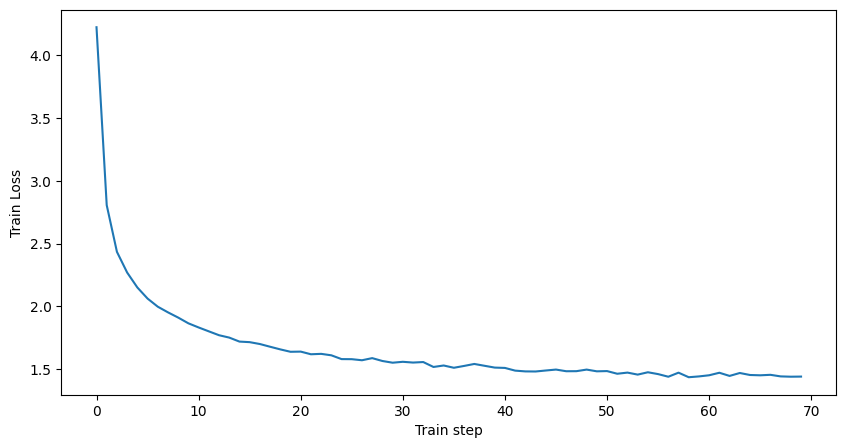

MyCharRNNLM(
  (embedding): Embedding(101, 128)
  (rnn): RNN(128, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=101, bias=True)
)
[1.2941588163375854, 1.349081039428711, 1.3873226642608643, 1.2951418161392212, 1.3378472328186035]


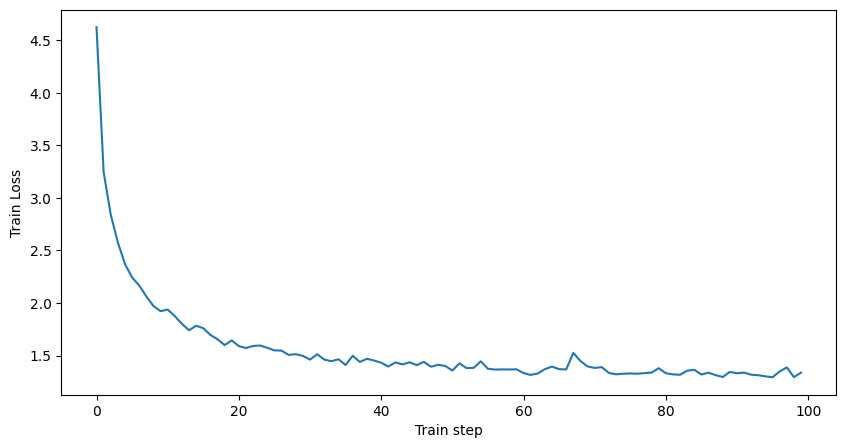

In [58]:
# Run the following to train the model
# Train on shakespear book
book_rnnlm = MyCharRNNLM(book_data.vocab_size, hidden_size, num_layers)
book_rnnlm = book_rnnlm.to(device)
print(book_rnnlm)
book_rnnlm = train_loop(
    book_rnnlm, book_data, 'book_rnnlm.pt', batch_size, num_epochs, device=device, report_every_step=10,
)

# Train on linux kernel code
code_loader = DataLoader(code_data, batch_size=batch_size, num_workers=8, shuffle=True)
code_rnnlm = MyCharRNNLM(code_data.vocab_size, hidden_size, num_layers)
code_rnnlm = code_rnnlm.to(device)
print(code_rnnlm)
code_rnnlm = train_loop(
    code_rnnlm, code_data, 'code_rnnlm.pt', batch_size, num_epochs, device=device, report_every_step=10,
)


## Task 3: Play with the trained RNN language model

**Task 3.1:** Load the trained model and generate sequences using it.

In this homework, we will use the simplest approach—selecting the character with the highest probability at each step. This method is known as the greedy decoding strategy for language models, implemented in `generate_text` function. While there are more advanced decoding strategies available, we use this as a simple demonstration.

Your task is to experiment with the two trained models by providing different prefix sequences and compare their generated outputs. Two example prefix is provided.

Write **one short sentence** summarizing your observation about the differences between the two models' generation results.

**One short sentence summarization of the observations:**

The model is too weak to generate more unique outputs based on the input text and choosing argmax is too basic to include any nuance, so the model repeats the same few words over and over.

In [66]:
def generate_text(model, prefix_str, dataset, predict_len=100):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    chars = list(prefix_str)
    input_seq = torch.tensor([dataset.char2idx.get(ch, 1) for ch in prefix_str], dtype=torch.long).unsqueeze(0).to(device)
    hidden = model.init_hidden(1).to(device)

    for _ in range(predict_len):
        output, hidden = model(input_seq, hidden)
        last_char_logits = output[0, -1]
        predicted_idx = torch.argmax(torch.softmax(last_char_logits, dim=0)).item()
        chars.append(dataset.idx2char[predicted_idx])
        input_seq = torch.tensor([[predicted_idx]], dtype=torch.long).to(device)
        if predicted_idx == 0: # early exit when model predicts to end the generation
            break

    return ''.join(chars)

In [68]:
code_prefix = "#include <"
text_prefix = "In sooth, my heart doth weigh "

with torch.inference_mode():
    #################################################
    ## TODO:  Play with the models!                ##
    #################################################
    # Call generate_text to experiment the two model with different prefixes
    code = generate_text(code_rnnlm, code_prefix, code_data, 200)
    text = generate_text(book_rnnlm, text_prefix, book_data, 200)
    print(code)
    print(text)

#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <linux/state.h>
#include <
In sooth, my heart doth weigh the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state the state 
